# Continuous treatment (i.e. continuous action space)

In [1]:
import torch
import confounding_robust_inference as cri

In [2]:
from matplotlib import pyplot as plt

plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

/tmp/ipykernel_1106759/711566762.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
beta = torch.as_tensor([1, 0.5, -0.5, 0, 0], dtype=TORCH_DTYPE)
policy = cri.policies.GaussianPolicy(beta)
data = cri.data.SyntheticDataContinuous()
Y, T, X, _, p_t, _ = data.sample(1000)

## Non-robust policy value

In [4]:
# Non-robust estimator of the policy value:
estimator = cri.estimators.IPWEstimator()
estimator.fit(Y, T, X, p_t, policy)
estimator.predict()

tensor(1.9869, dtype=torch.float64)

In [5]:
# We can also compute the theoretical non-robust policy value by Monte Carlo sampling with the true data distribution:
data.evaluate_policy(policy, n_mc=100000)

tensor(2.7728, dtype=torch.float64)

## Robust policy value

In [6]:
# Robust estimator of the policy value:
estimator = cri.estimators.KCMCEstimator(
    const_type="lr_box", Gamma=1.5, D=50, rescale_by_policy_prob=True
)
estimator.fit(Y, T, X, p_t, policy)
estimator.predict()

tensor(1.5561, dtype=torch.float64)

In [8]:
# We can also compute the theoretical robust policy value by Monte Carlo sampling with the true data distribution:
data.evaluate_policy_lower_bound(policy, n_mc=100000, Gamma=1.5)

tensor(2.4270, dtype=torch.float64)

## Visualize the bounds by KCMC and QB estimators

In [9]:
Gammas = [1 + i / 10 for i in range(11)]


def get_bound(estimator_type, direction, Gamma):
    estimator = {
        "KCMC": cri.estimators.KCMCEstimator(
            const_type="lr_box", Gamma=Gamma, D=20, rescale_by_policy_prob=True
        ),
        "QB": cri.estimators.QBEstimator(const_type="lr_box", Gamma=Gamma, D=20),
    }[estimator_type]
    if direction == "lower":
        return estimator.fit(Y, T, X, p_t, policy).predict()
    elif direction == "upper":
        return -estimator.fit(-Y, T, X, p_t, policy).predict()
    else:
        raise ValueError


lower_bounds_kcmc = [get_bound("KCMC", "lower", Gamma) for Gamma in Gammas]
upper_bounds_kcmc = [get_bound("KCMC", "upper", Gamma) for Gamma in Gammas]

lower_bounds_qb = [get_bound("QB", "lower", Gamma) for Gamma in Gammas]
upper_bounds_qb = [get_bound("QB", "upper", Gamma) for Gamma in Gammas]

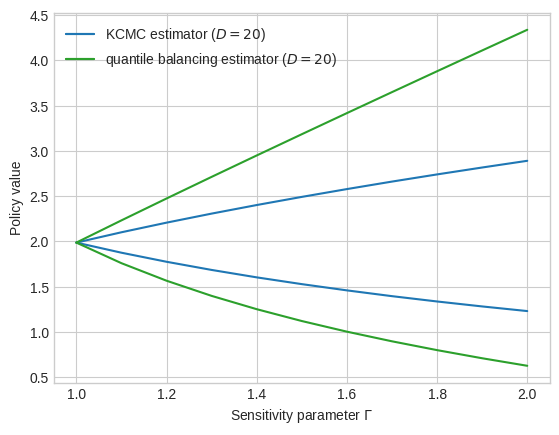

In [10]:
lower_line_kcmc = plt.plot(Gammas, lower_bounds_kcmc, color=tab10(0))[0]
upper_line_kcmc = plt.plot(Gammas, upper_bounds_kcmc, color=tab10(0))[0]
lower_line_qb = plt.plot(Gammas, lower_bounds_qb, color=tab10(2))[0]
upper_line_qb = plt.plot(Gammas, upper_bounds_qb, color=tab10(2))[0]

plt.legend(
    [(lower_line_kcmc, upper_line_kcmc), (lower_line_qb, upper_line_qb)],
    ["KCMC estimator ($D=20$)", "quantile balancing estimator ($D=20$)"],
    loc="upper left",
)
plt.xlabel(r"Sensitivity parameter $\Gamma$")
plt.ylabel(r"Policy value")
plt.savefig("fig/continuous_treatment_kcmc_vs_qb.pdf")